<h1><u><center> Economic Scenario Generator Project - Projet DDEFI </center></u></h1>
<img src = "https://www.econostrum.info/photo/art/grande/36648656-32651177.jpg?v=1566465679" 
     title = "NASDAQ Logo" alt = "Nasdaq Logo" width="300">

<h3><center> Anaïs Auzanneau / Vincent Bilger / Alison Cortesi / Germain Lefebvre / Julien Levacque / Florent Morin </center></h3>

<h4><center> - </h4></center>
<h4><center> École Centrale Marseille </h4></center>

### Sommaire  <a class="anchor" id="sommaire"></a>

[Préliminaire - État de l'art](#Etat_Art)

* [0 - Importation des ressources](#chapter0)
    * [Important : Définition de la classe "Series"](#chapter0.important)


* [I - Préparation de notre data set pour la simulation](#chapter1)
    * [I.1 - Conversion des données en rendements logarithmiques](#chapter1.1)
    * [I.2 - Split de notre data set](#chapter1.2)
    
    
* [II - Modélisation paramétrique](#chapter2)
    * [II.1  Modèle GARCH(p,q)](#chapter2.section1)
    * [II.2 - Simulations grâce à notre modèle GARCH(p,q)](#chapter2.section2)


        
* [III- Historical Simulation (Bootstrapping)](#chapter3)


* [IV - Filtred Historical Simulation ](#chapter4)


* [V - Fonction de performance](#chapter5) 
    * [V.1 - Fonctions de mesures](#chapter5.section1)
    * [V.2 - Fonction Describe](#chapter5.section2)
    
    
* [VI - Generative Adversarial Network (GAN)](#chapter6)




## Préliminaires - État de l'art <a class="anchor" id="Etat_Art"></a>

### Articles

<strong>[1]</strong> <i>Filtering Historical Simulation. Backtest Analysis</i>, by Giovanni Barone-Adesi, Kostas Giannopoulos and Les Vosper (2000)

<strong>[2]</strong> <i>An Unsupervised Deep Learning Approach for Scenarios Forecasts</i>, by Yize Chen, Xiyu Wang, and Baosen Zhang (2018)

<strong>[3]</strong> <i>The Market Generator</i>, by Alexei Kondratyev and Christian Schwarz (2020)

<strong>[4]</strong> <i>Non-parametric VaR Techniques. Myths and Realities</i>, by Giovanni Barone-Adesi and Kostas Giannopoulos (2001)

### Etat de l'art

<div style="text-align: justify">
Un générateur de scénarios économiques simule des projections sur un horizon donné de différents facteurs de risques : taux d’intérêt, rendements d’actifs, inflation, taux de change etc. Différentes approches existent pour prédire ces scénarios. Dans ce projet, nous nous intéresserons en particulier aux méthodes de Filtered Historical Simulation (FHS) et de Machine Learning, notamment à la classe de réseaux Generative Adversarial Networks (GAN). 
La méthode de <strong>Historical Simulation</strong> (HS) consiste à tirer aléatoirement des rendements parmi la liste des rendements historiques disponibles, et à les concaténer pour former un scénario de valeurs possibles. On peut ensuite obtenir un grand nombre de scénarios différents en répétant l’opération. Le FHS est un HS généralisé et permet d’en contrer les inconvénients. Dans la méthode du FHS, les rendements historiques sont préalablement standardisés par la volatilité estimée du jour correspondant. Cet ajout permet de prendre en compte l’état actuel du marché et d’adapter les prédictions. <strong>[1] [4]</strong></div>
<br></br>
<div style="text-align: justify">
Le <strong>Generative Adversarial Networks</strong> (GAN) est, comme son nom l’indique, un procédé qui met en compétition deux réseaux de neurones aux fonctions bien distinctes. D’une part, le generator, l’artiste, apprend à créer des images de manière à ce qu’elles apparaissent les plus réelles possibles. En face, le discriminator est le critique, c'est-à-dire qu’il a pour mission d’apprendre à distinguer les vraies images des fausses, ces dernières étant générées par le generator. Le GAN confronte en permanence les deux réseaux, et chacun s’améliore à chaque “défaite”. L’équilibre est finalement atteint lorsque le discriminant ne parvient plus à distinguer. <strong>[2]</strong>
</div>
<br></br>
<div style="text-align: justify">
Enfin, les réseaux de type <strong>Restricted Boltzmann Machine</strong> (RBM) permettent de répliquer la distribution de probabilité d’un jeu de données historiques. L’ensemble du réseau est doté d’une énergie basée sur les neurones stochastiques à activation binaires. L’apprentissage consiste à minimiser la log-vraisemblance des données pour approcher la distribution de probabilité réelle, et se déroule en deux phases : la phase “positive”, où les neurones visibles sont raccordés à la distribution de probabilité, et la phase “négative” où le réseau fonctionne librement. Une descente de gradient permet d’atteindre l’équilibre. <strong>[3]</strong>
</div>
<br></br>

## 0 - Importation des ressources <a class="anchor" id="chapter0"></a>

In [1]:
# conda install -c saravji pmdarima
# conda install -c conda-forge statsmodels

import pandas as pd                                       #Used in all section
import numpy as np                                        #Used in all section
from math import *                                        #Used in all section

import time                                               #Used in section 0
import datetime                                           #Used in section 0
from datetime import date                                 #Used in section 0


import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


import random                                             #Used in section 4 and 5
import matplotlib.pyplot as plt                           #Used in all section
import plotly.graph_objects as go                         #Used in section 4.3
plt.style.use('ggplot')
from statsmodels.stats.weightstats import ztest           #Used in section 5.1
from scipy import stats                                   #Used in section 5.1
from scipy.stats import f_oneway                          #Used in section 5.1 
from scipy.stats import mannwhitneyu                      #Used in section 5.1
from scipy.stats import wasserstein_distance              #Used in section 5.1
from scipy.stats import wilcoxon                          #Used in section 5.1


# Special GAN
import warnings                                                           #Used in section 6
warnings.filterwarnings('ignore')                                         #Used in section 6
from sklearn.preprocessing import MinMaxScaler                            #Used in section 6
import tensorflow as tf                                                   #Used in section 6
from pathlib import Path                                                  #Used in section 6
from tqdm import tqdm                                                     #Used in section 6

from tensorflow.keras.models import Sequential, Model                     #Used in section 6
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input       #Used in section 6
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError  #Used in section 6
from tensorflow.keras.optimizers import Adam                              #Used in section 6
from tensorflow.keras.callbacks import TensorBoard                        #Used in section 6
from tensorflow.keras.utils import plot_model                             #Used in section 6

import seaborn as sns                                                     #Used in section 6

$! Attention !$ Ne pas oublier de changer le chemin ci-dessous en fonction de l'utilisateur afin d'arriver au fichier contenant les bases de données.

In [2]:
# root_path = 'C:/Users/anais/Documents/Centrale/Cours/3A/DDEFi/Projet DDEFi/Ressources/Data/'      #Anais
root_path = 'C:/Users/33649/Desktop/A3/Projet DDEFI/BP2S/Code_Data_2020/BDD/'                         #Germain
#root_path = 'C:/Users/flomo/Desktop/Projet BNP/Data/'                                             #Florent
# root_path = 'C:/Users/Vincent/Desktop/PROJET DDEFI/DATA/'                                         #Vincent
# root_path = 'C:/Users/alisoncortesi/Desktop/ECM_3A/OPT_DDEFI/TC_PROJDDEFI                         #Alison
# root_path = 'D:/Utilisateurs/JLEQ/BP2S/Datas/'                                                    #Julien

Importation de nos 3 bases d'indices afin de pouvoir selectionner les données souhaitées.

In [3]:
Actions = pd.read_csv(root_path+'BDD_Index.csv')
Taux = pd.read_csv(root_path+'BDD_Rates.csv')
Echanges = pd.read_csv(root_path+'BDD_Exchange.csv')
Stocks = pd.read_csv(root_path+'StoxxSnP500_3.csv')

Actions['Date'] = pd.to_datetime(Actions['Date'])
Actions = Actions.set_index(keys = 'Date', drop = True)

Stocks['Date'] = pd.to_datetime(Stocks['Date'])
Stocks = Stocks.set_index(keys = 'Date', drop = True)

Taux['Date'] = pd.to_datetime(Taux['Date'])
Taux = Taux.set_index(keys = 'Date', drop = True)

Echanges['Date'] = pd.to_datetime(Echanges['Date'])
Echanges = Echanges.set_index(keys = 'Date', drop = True)


Importation des bases de données générées par les GAN (Stocks & Taux)

In [4]:
# Clone les données présentes dans le git
!git clone https://github.com/GEL63870/ddefi_project.git

#Chargement des données
!cd ddefi_project

fatal: destination path 'ddefi_project' already exists and is not an empty directory.


In [5]:
# Nouveau Root_path
root = 'C:/Users/33649/Desktop/A3/Projet DDEFI/BP2S/Code_Data_2020/ddefi_project/Generated_data/'           #Germain LEFEBVRE

# Récupérer les BDD du GAN
GAN_Stocks = np.load(root + 'np_model_stocks3.h5.npy')
GAN_Taux = np.load(root + 'np_model_Taux.h5.npy')

Afin de mieux visualiser les données à notre disposition, nous commençons par tracer l'évolution temporelle de nos données brutes.

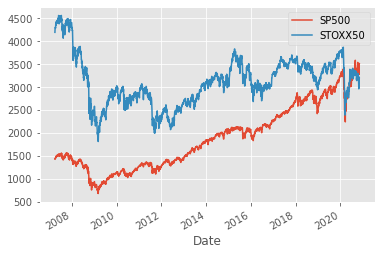

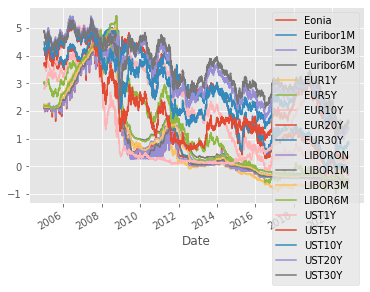

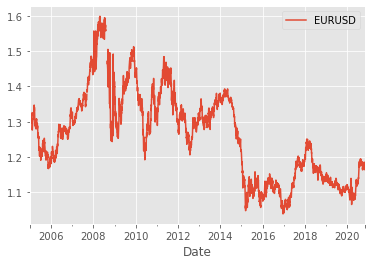

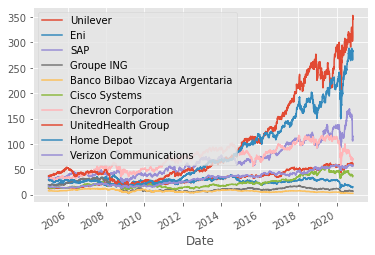

In [6]:
Actions.plot()
Taux.plot()
Echanges.plot()
Stocks.plot()

<div style="text-align: justify">
Afin de pouvoir étudier un panel important de données, et notamment des taux, nous importons ici un grand nombre de fichiers.
Dans un premier temps, toutes les données importées ne seront pas utilisées.
</div>  
<br></br>
Dans les 6 prochains chapitres, nous ne nous interesserons qu'aux deux indices STOXX50 et S&P500.

Ci-dessous, un schéma récapitulatif des données aggrégées : 
<div>

    
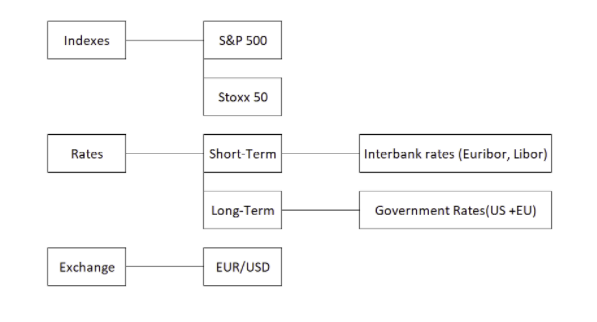

### Fonctions Statistiques

In [7]:
#This function calculates the absolute median deviation of a distribution function.
def Median_Abs_dev(data):    
    mads =[]
    for col in data.columns:
        series = data[col]
        mads.append(series.mad())
    return(mads)
    
#This function calculates the skewness value of a distribution function    
def skewness(data):    
    skews =[]
    for col in data.columns:
        series = data[col]
        skews.append(series.skew())
    return(skews)

#This function calculates the kurtosis value of a distribution function
def kurtosis(data):
    kurtos =[]
    for col in data.columns:
        series = data[col]
        kurtos.append(series.kurt())
    return(kurtos)
    
    
#  ! WARNING ! -> This function calculates the Z-Score of one distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def Z_score(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)        

    
#  ! WARNING ! -> This function calculates the t-Score of two distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def t_score(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        
        else:
            series = data[col]
            stat_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)     

    
#  ! WARNING ! -> This function calculates the F-test of two distributions
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def F_test(data, percentage_test):
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)     

    
#  ! WARNING ! -> This function calculates the Wilcoxon Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def Wilcoxon(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col] 
            stat_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)     


#  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def Mann_Whitneyu(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)     


#  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
def Wasserstein(data) :
    res = []
    for col in data.columns:
        series = data[col]
        res.append(wasserstein_distance(data['Testing Set'], data[col]))
    return(res)


### <u> Important </u> : Définition de la classe "Series"  <a class="anchor" id="chapter0.important"></a>

In [56]:
class Series:
    
    def __init__(self, name, values, type_serie, gan_values, ticker_gan):
        self.name = name # nom de la série
        self.values = values # dataframe des valeurs
        self.type_serie = type_serie
        self.gan_values = gan_values  #generated data du GAN
        self.ticker_gan = ticker_gan  #Selectionner la bonne colonne du GAN
    
    # Fonction qui plot les données
    def visualization(self):
        plt.plot(self.values)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Evolution of ' + self.name)
    
    # Fonction qui plot et retourne le tableau des valeurs des rendements
    def returns(self):
        if self.type_serie == "Action":
            var_pct = self.values.pct_change().dropna()
            rdmt = np.log(1 + var_pct)
        if self.type_serie == "Taux":
            rdmt = self.values.diff().dropna()
        plt.plot(rdmt)
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.title('Daily Logarithmic Returns for ' + self.name)
        return(rdmt)
    
    # Fonction qui renvoie la partie "training" du dataset
    def split_data(self):
        ret = self.returns()
        plt.close()
        T = ceil(len(ret.index)*0.8)
        train = ret[:T]     
        test = ret[T:]
        return(train, test)
    
    ##############################################################################
    ##############################################################################  
 
    # Fonction qui utilise la méthode HS (simple bootstrap) pour prédire les rendements/prix
    def historical_simulation(self,nb_paths):
        training_data, testing_data  = self.split_data()
        depart = float(self.values.iloc[len(training_data)-1])
        
        # Boostrapping
        random.seed(43)
        bootstrapped_returns = pd.DataFrame([random.choices(list(training_data.iloc[:,0]), k=len(testing_data)) for i in range(nb_paths)]).T
        bootstrapped_returns.index = testing_data.index
        
        res = bootstrapped_returns
        #Graphique 1
        bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements bootstrappés, nombre de chemins = '+str(nb_paths))
        bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        #Graphique 2
        data=self.values
        bootstrapped_prices = (1+bootstrapped_returns).shift(1).fillna(depart).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        if self.type_serie == "Action":
            plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        if self.type_serie == "Taux":
            plt.title('Scénarios de taux interet, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')

        return(res)
    
    ##############################################################################
    ##############################################################################
    
    ## Fonction qui utilise la méthode FHS (bootstrapping sur rendements standardisés, avec fenêtre glissante pour le calcul de la vol.) pour prédire les rendements/prix    
    def filtered_historical_simulation_glissant(self,nb_paths,len_fenetre):          
        
        training_data, testing_data = self.split_data()
        depart = float(self.values.iloc[len(training_data)])
        
        ######## Filtration - Fenetre glissante ########
        vol = []
        for i in range(len_fenetre,len(training_data)):
            vol.append(np.std(training_data[self.name][i-len_fenetre:i]))
        vol2 = [vol[0] for i in range(0, len_fenetre)]
        vol2.extend(vol)
        vol2 = pd.DataFrame(vol2, columns = ['vol'])
        vol2.index = training_data.index
        vol2['rdt_std'] = training_data[self.name]/vol2['vol']
        vol2[self.name] = training_data[self.name]
        
        init_copy_vol2 = vol2
        ######## Boostrapping - 'Nb_paths' scénarios de longueur 'Testing_data' ########
        filtred_bootstrapped_returns = pd.DataFrame([random.choices(list(vol2['rdt_std']), k=len(testing_data)) for i in range(nb_paths)]).T
        
        res = pd.DataFrame([])
        for i in range(0,nb_paths):
            vol2 = init_copy_vol2
            for j in range(0,len(testing_data)):
                vol = vol2['vol'].iloc[-1]                        #Voir excel 
                rdtstd = filtred_bootstrapped_returns[i][j]               #Voir excel
                stoxx = vol * rdtstd                              #Voir excel
                list_rdt = list(vol2[self.name][-len_fenetre-1:]) #Sliding window de 20, on prend les 19 dernières valeurs +
                list_rdt.append(stoxx)                            #la 20ème valeur
                vol = np.std(list_rdt)
                add = pd.DataFrame([[vol, rdtstd, stoxx]])        #Mise en forme des données générés
                
                ## Ajout au dataframe calculé dans la partie 1
                add.columns = vol2.columns                        
                vol2 = vol2.append(add)
            
            ## Ajout du scenario FHS généré dans le fichier de sauvegarde
            idx = str(i)
            res[idx] = vol2[self.name][-len(testing_data):]
        
        ## Mise en forme de l'ensemble des scénari FHS générés
        res.index = testing_data.index
        filtred_bootstrapped_returns = res
            
        ##Graphique 1
        filtred_bootstrapped_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements bootstrappés, nombre de chemins = '+str(nb_paths))
        filtred_bootstrapped_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        filtred_bootstrapped_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        filtred_bootstrapped_returns.mean(1).plot(label='Moyenne',color='r')
        
        #Graphique 2
        data=self.values
        bootstrapped_prices = (1+filtred_bootstrapped_returns).shift(1).fillna(depart).cumprod()
        bootstrapped_prices.index = testing_data.index
        bootstrapped_prices.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        if self.type_serie == "Action":
            plt.title('Scénarios de prix, nombre de chemins = '+str(nb_paths))
        if self.type_serie == "Taux":
            plt.title('Scénarios de taux interet, nombre de chemins = '+str(nb_paths))
        plt.plot(data,color ='black')
        bootstrapped_prices.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        bootstrapped_prices.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        bootstrapped_prices.mean(1).plot(label='Moyenne',color='r')
        
        return(filtred_bootstrapped_returns)

    ##############################################################################
    ##############################################################################

    # Fonction qui utilise les données issues du GAN pour prédire les rendements/prix
    def gan_simulation(self):
        
        #Importation du testing set
        training_data, testing_data = self.split_data()
        len_test = len(testing_data)

        depart = float(self.values.iloc[len(training_data)]) #Pour le graph 2
      
        #Importation des données du GAN
        generated_data = self.gan_values
        ticker_gan = self.ticker_gan
        nbr_seq = len(generated_data)
        seq_len = len(generated_data[0])

        # Préparation des boucles : 
        seq_per_path = int(len_test/seq_len) + 1
        path_per_data = int(nbr_seq/seq_per_path)

        #Création des scénarios à partir des séquences de 24:
        transpo = []
      
        gan_returns = pd.DataFrame()
    
        # Création du dataframe de scénarios
        for j in range(path_per_data):
            paths = []
            for i in range(j*seq_len, j*seq_len + seq_per_path + 1):
                transpo = generated_data[i].T
                paths = paths + list(transpo[ticker_gan])     # Numéro de la colonne que l'on veut dans le GAN (exemple SP500 placé en 0) 
        
        # On rabote le scénario pour qu'il soit à la bonne taille - On en ajoute 1 pour anticiper le Nan issu du calcul de rendement
            diff = len(paths) - len_test
            if diff != 0:
                paths = paths[:len(paths)- diff + 1] 

            # Ajout du path crée dans le dataframe GAN
            gan_returns[j+1] = paths

        # Mise en forme du dataframe - Rendements !
        if self.type_serie == "Action":
            var_pct = gan_returns.pct_change().dropna()
            gan_rdmt = np.log(1 + var_pct)
        if self.type_serie == "Taux":
            gan_rdmt = gan_returns.diff().dropna()

        # La ligne en trop a été drop grâce au Dropna, on finit avec les bons index
        gan_rdmt.index = testing_data.index

        #Graphique 1
        gan_rdmt.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        plt.title('Rendements GAN, nombre de chemins = '+str(path_per_data))
        gan_rdmt.quantile(0.05,1).plot(label='Quantile 95%',color='b')  
        gan_rdmt.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        gan_rdmt.mean(1).plot(label='Moyenne',color='r')
        
        # ## Graphique 2
        # data=self.values
        # # gan_returns = (1+gan_returns).shift(1).fillna(depart).cumprod()
        # # gan_returns.index = testing_data.index
        # # gan_returns.plot(figsize=(15,8), legend=False, linewidth=1, alpha=0.2)
        # # if self.type_serie == "Action":
        # #   plt.title('Scénarios de prix, nombre de chemins = '+str(path_per_data))
        # # if self.type_serie == "Taux":
        # #   plt.title('Scénarios de taux interet, nombre de chemins = '+str(path_per_data))
        # plt.plot(data,color ='black')
        # gan_returns.quantile(0.05,1).plot(label='Quantile 95%',color='b')
        # gan_returns.quantile(0.95,1).plot(label='Quantile 5%',color='b')
        # gan_returns.mean(1).plot(label='Moyenne',color='r')

        return (gan_rdmt)

    ##############################################################################
    ##############################################################################
    
    # Fonction qui compare les résultats de nos différentes méthodes
    def describe(self, nb_paths, len_fenetre, percentage_test):
        
        ##On recup les DataFrame de 667x500 issus de HS & FHS
        simulated_data_HS = self.historical_simulation(nb_paths)
        plt.close()
        simulated_data_FHS_glissant = self.filtered_historical_simulation_glissant(nb_paths, len_fenetre)
        plt.close()
        simulated_data_GAN = self.gan_simulation()
        plt.close()
        training_data, testing_data = self.split_data()
        plt.close()
        plt.clf()
               
        #################################################################################################
        ###################### Réalisation du DataFrame Describe des scénarios HS #######################
        #################################################################################################        
        
        ## On prépare le DataFrame 
        Data_hs = pd.DataFrame({'Testing Set' : list(testing_data.iloc[:,0])}, index=testing_data.index)
        Data_hs = pd.concat([Data_hs, simulated_data_HS], axis = 1)
        
        ## Première opération classique ne necessitant pas de comparaison 
        res_hs = Data_hs.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
        res_hs.loc['Median Absolute Deviation'] = Median_Abs_dev(Data_hs) #Add MAD measurement to the recap table
        res_hs.loc['skew'] = skewness(Data_hs)                                   #Add skew measurement to the recap table
        res_hs.loc['kurtosis'] = kurtosis(Data_hs)                               #Add kurtosis measurement to the recap table
        
        ## Marche uniquement si notre Dataframe à 2 indices ou plus
        if len(Data_hs.columns) > 1 : 
            res_hs.loc['Wasserstein Distance'] = Wasserstein(Data_hs)
            res_hs.loc['Wilcoxon Test'] = Wilcoxon(Data_hs, percentage_test)[0]
            res_hs.loc['Wilcoxon H0 % Acceptance'] = Wilcoxon(Data_hs, percentage_test)[1]
            res_hs.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(Data_hs, percentage_test)[0]
            res_hs.loc['Mann-Whitneyu H0 % Acceptance'] = Mann_Whitneyu(Data_hs, percentage_test)[1]
            res_hs.loc['F_test'] = F_test(Data_hs, percentage_test)[0]
            res_hs.loc['F_test H0 % Acceptance'] = F_test(Data_hs, percentage_test)[1]
            res_hs.loc['t_test'] = t_score(Data_hs, percentage_test)[0]
            res_hs.loc['t_test H0 % Acceptance'] = t_score(Data_hs, percentage_test)[1] 
            res_hs.loc['Z_test'] = Z_score(Data_hs, percentage_test)[0]
            res_hs.loc['Z_test H0 % Acceptance'] = Z_score(Data_hs, percentage_test)[1]
        
        #################################################################################################
        ##################### Réalisation du DataFrame Describe des scénarios FHS #######################
        #################################################################################################
        Data_fhs = pd.DataFrame({'Testing Set' : list(testing_data.iloc[:,0])}, index=testing_data.index)
        Data_fhs = pd.concat([Data_fhs, simulated_data_FHS_glissant], axis = 1)
        
        ## Première opération classique ne necessitant pas de comparaison 
        res_fhs = Data_fhs.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
        res_fhs.loc['Median Absolute Deviation'] = Median_Abs_dev(Data_fhs) #Add MAD measurement to the recap table
        res_fhs.loc['skew'] = skewness(Data_fhs)                                   #Add skew measurement to the recap table
        res_fhs.loc['kurtosis'] = kurtosis(Data_fhs)                               #Add kurtosis measurement to the recap table
        
        ## Marche uniquement si notre Dataframe à 2 indices ou plus
        if len(Data_fhs.columns) > 1 : 
            res_fhs.loc['Wasserstein Distance'] = Wasserstein(Data_fhs)
            res_fhs.loc['Wilcoxon Test'] = Wilcoxon(Data_fhs, percentage_test)[0]
            res_fhs.loc['Wilcoxon H0 % Acceptance'] = Wilcoxon(Data_fhs, percentage_test)[1]
            res_fhs.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(Data_fhs, percentage_test)[0]
            res_fhs.loc['Mann-Whitneyu H0 % Acceptance'] = Mann_Whitneyu(Data_fhs, percentage_test)[1]
            res_fhs.loc['F_test'] = F_test(Data_fhs, percentage_test)[0]
            res_fhs.loc['F_test H0 % Acceptance'] = F_test(Data_fhs, percentage_test)[1]
            res_fhs.loc['t_test'] = t_score(Data_fhs, percentage_test)[0]
            res_fhs.loc['t_test H0 % Acceptance'] = t_score(Data_fhs, percentage_test)[1] 
            res_fhs.loc['Z_test'] = Z_score(Data_fhs, percentage_test)[0]
            res_fhs.loc['Z_test H0 % Acceptance'] = Z_score(Data_fhs, percentage_test)[1]
        

        #################################################################################################
        ##################### Réalisation du DataFrame Describe des scénarios GAN #######################
        #################################################################################################
        Data_GAN = pd.DataFrame({'Testing Set' : list(testing_data.iloc[:,0])}, index=testing_data.index)
        Data_GAN  = pd.concat([Data_GAN , simulated_data_GAN], axis = 1)
        
        ## Première opération classique ne necessitant pas de comparaison 
        res_GAN = Data_GAN.describe()             #Create the table with Mean / std / Min / 1st quartile / Meadian /1 3rd quartile / Max
        res_GAN.loc['Median Absolute Deviation'] = Median_Abs_dev(Data_GAN) #Add MAD measurement to the recap table
        res_GAN.loc['skew'] = skewness(Data_GAN)                                   #Add skew measurement to the recap table
        res_GAN.loc['kurtosis'] = kurtosis(Data_GAN)                               #Add kurtosis measurement to the recap table
        
        ## Marche uniquement si notre Dataframe à 2 indices ou plus
        if len(Data_GAN.columns) > 1 : 
            res_GAN.loc['Wasserstein Distance'] = Wasserstein(Data_GAN)
            res_GAN.loc['Wilcoxon Test'] = Wilcoxon(Data_GAN, percentage_test)[0]
            res_GAN.loc['Wilcoxon H0 % Acceptance'] = Wilcoxon(Data_GAN, percentage_test)[1]
            res_GAN.loc['Mann-Whitneyu Test'] = Mann_Whitneyu(Data_GAN, percentage_test)[0]
            res_GAN.loc['Mann-Whitneyu H0 % Acceptance'] = Mann_Whitneyu(Data_GAN, percentage_test)[1]
            res_GAN.loc['F_test'] = F_test(Data_GAN, percentage_test)[0]
            res_GAN.loc['F_test H0 % Acceptance'] = F_test(Data_GAN, percentage_test)[1]
            res_GAN.loc['t_test'] = t_score(Data_GAN, percentage_test)[0]
            res_GAN.loc['t_test H0 % Acceptance'] = t_score(Data_GAN, percentage_test)[1] 
            res_GAN.loc['Z_test'] = Z_score(Data_GAN, percentage_test)[0]
            res_GAN.loc['Z_test H0 % Acceptance'] = Z_score(Data_GAN, percentage_test)[1]


        #################################################################################################
        ####### Réalisation Tableau Describe à partir des describe de chaque scénario généré ############
        #################################################################################################        
        
        ## On prépaer notre tableau final
        res = pd.DataFrame({'Testing Set' : list(res_hs['Testing Set'])}, index=res_hs.index)
        
        ## On supprime les columns Testing Set de nos tableaux HS & FHS pour pouvoir réaliser nos comparaisons
        res_hs = res_hs.drop(columns=['Testing Set'])
        res_fhs = res_fhs.drop(columns=['Testing Set'])
        res_GAN = res_GAN.drop(columns=['Testing Set'])
        
        ## On prépare les dataframe des moyennes de chacunes des mesures effectuées
        hs_df = pd.DataFrame({'Historical Simulation' : list(res_hs.mean(axis = 1))}, index = res_hs.index)
        fhs_df = pd.DataFrame({'Filtered HS' : list(res_fhs.mean(axis = 1))}, index = res_fhs.index)
        GAN_df = pd.DataFrame({'Generative Adversarial Network' : list(res_GAN.mean(axis = 1))}, index = res_GAN.index)
        
        ##On prépare le tableau à retourner
        res = pd.concat([res, hs_df, fhs_df, GAN_df], axis=1)
        
        # On découpe le tableau en deux parties - Mesures statistiques / Tests Statistiques
        mesure = pd.DataFrame(res.iloc[[i for i in range (11)]])
        
        test = res.drop(columns=['Testing Set'])
        test = pd.DataFrame(test.iloc[[i for i in range (11,22)]])
        
        #On rajoute un titre pour chaque dataframe
        mesure = mesure.style.set_caption('Mesure statistiques  ' + self.name + ', Nombre de chemin = ' + str(nb_paths) + ', Longueur Fenetre = ' + str(len_fenetre))
        test = test.style.set_caption('Tests statistiques  ' + self.name+ ', Nombre de chemin = ' + str(nb_paths) + ', Longueur Fenetre = ' + str(len_fenetre) + ', Seuil H0 Test Statistique = ' + str((1-percentage_test)*100) + ' %')
        
        return mesure, test

Commençons par choisir une série de données à étudier.

In [57]:
serie = Series("Euribor6M", Taux[['Euribor6M']], "Taux", GAN_Taux, 3)

## I - Préparation de notre data set pour la simulation <a class="anchor" id="chapter1"></a>

[Retour Sommaire](#sommaire)

#### I.1 - Conversion des données en rendements logarithmiques <a class="anchor" id="chapter1.1"></a>


,Euribor6M
Date,
2005-01-04,0.001
2005-01-05,-0.002
2005-01-06,-0.001
2005-01-07,-0.014
2005-01-10,0.005
...,...
2020-11-02,0.008
2020-11-03,0.000
2020-11-04,-0.002


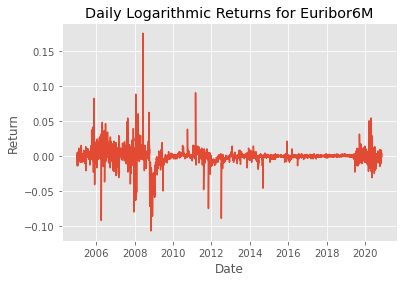

In [10]:
serie.returns()

<u>Remarque:</u> On voit bien les fortes variations en 2009 (crise financière) et idem en début 2020 (crise du COVID-19)

#### I.2 - Split de notre dataset <a class="anchor" id="chapter1.2"></a>

[Retour Sommaire](#sommaire)

On sépare ensuite notre data set en deux.

- La première partie (80%) correspond au Training Set
- La seconde partie (20%) correspond au Testing Set

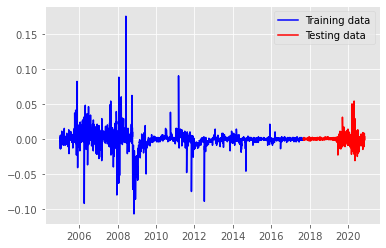

In [11]:
training_data, testing_data = serie.split_data()
plt.plot(training_data,c='b',label='Training data')
plt.plot(testing_data,c='r',label='Testing data')
plt.legend()

## II - Modélisation paramétrique <a class="anchor" id="chapter2"></a>

[Retour Sommaire](#sommaire)

Nous avons voulu dans un premier temps réaliser une méthode simple de modélisation et de prédiction. L'objectif était tout d'abord de manipuler nos set de données, mais aussi d'apprécier la performance de ce type de méthode afin de les comparer avec les méthodes plus complexes que nous étudierons par la suite.

#### II.1 - Modèle GARCH(p,q)  <a class="anchor" id="chapter2.section1"></a>

Pour trouver le modèle le plus adapté à notre série temporelle, nous allons utiliser une fonction de performance et nous allons déterminer les paramètres p et q optimaux pour notre modèle GARCH(p,q).

On rappelle le format général d'un modèle GARCH(p,q): 
$$ \sigma^{2}_{t} = \omega + \sum_{j=1}^{q}\alpha_{j}\epsilon^{2}_{t-j}  +  \sum_{j=1}^{p}\beta_{j}\sigma^{2}_{t-j}  $$

Par exemple, si p=q=1, cela signifie que :

$$ r_{t} = \mu + \epsilon_{t} $$

$$ \sigma^{2}_{t} = \omega + \alpha \epsilon^{2}_{t-1} + \beta \sigma^{2}_{t-1} $$

$$ \epsilon_{t} = \sigma_{t}e_{t} $$ 
with $ e_{t}\sim N(0,1) $

In [12]:
# best_pq , model_garch = serie.garch(5,5)
# model_garch.summary()

#### II.2 - Simulations grâce à notre modèle GARCH (p,q)  <a class="anchor" id="chapter2.section2"></a>

In [13]:
# serie.garch_modelisation(5,5)

Les résultats ne semblent pas concluant avec ce modèle, il ne peut pas être utilisé pour la suite.

Dans un prochain chapitre, nous reviendrons sur ces prédictions et nous réaliserons une comparaison plus poussée, notamment par rapport aux valeurs réelles, grâce à différentes mesures. Nous comparerons aussi leur performance par rapport au modèle que nous allons décrire dans le prochain chapitre, le boostrapping.

## III - Historical Simulation (Bootstrapping) <a class="anchor" id="chapter3"></a>

[Retour Sommaire](#sommaire)

On réalise un bootstrapping sur les rendements de notre série de données. Nous générons pour cela 1000 scénarios issus du réechantillonage de notre Training set.

On calcule sur l'ensemble de nos scénarios générés par bootstrapping : 

- <strong>le quantile à 5% et 95% </strong>
- <strong>le quantile à 95% </strong>
- <strong>la moyenne </strong>

Puis on affiche le graphique comprenant ces trois mesures.

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-31,0.005,0.000,0.001,-0.054,-0.005,-0.012,-0.004,0.000,-0.002,0.000,...,-0.005,0.006,0.011,0.000,-0.040,-0.002,0.007,0.001,0.011,0.000
2017-09-01,0.001,-0.001,0.006,-0.001,-0.041,-0.001,0.001,0.000,0.001,-0.005,...,-0.011,-0.002,0.000,0.000,0.000,-0.001,-0.001,0.007,0.000,-0.002
2017-09-04,0.009,-0.003,0.002,-0.010,0.000,0.001,0.001,0.001,0.001,-0.001,...,-0.001,-0.002,0.046,-0.003,-0.007,-0.002,-0.089,0.000,-0.001,0.002
2017-09-05,0.000,-0.012,0.003,-0.002,-0.001,-0.001,0.001,0.000,-0.001,0.039,...,-0.001,0.000,0.001,0.000,0.008,0.000,0.000,0.000,-0.010,0.019
2017-09-06,0.001,0.001,-0.001,-0.004,-0.002,0.008,-0.001,0.005,0.002,0.009,...,0.000,0.007,0.000,0.006,0.006,0.024,0.014,-0.004,-0.002,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,0.004,-0.002,0.001,0.000,0.000,0.001,0.036,0.005,-0.007,-0.002,...,-0.003,-0.001,0.008,0.002,0.007,0.000,0.013,0.000,0.015,0.000
2020-11-03,-0.007,-0.005,0.001,-0.001,-0.009,0.000,0.000,0.013,0.005,-0.001,...,0.001,0.008,-0.002,-0.002,0.000,0.006,-0.004,-0.003,-0.001,0.001
2020-11-04,-0.001,-0.001,-0.001,-0.009,-0.002,-0.026,0.002,0.013,0.003,0.002,...,0.002,-0.007,0.003,0.003,-0.006,0.011,0.008,-0.002,0.000,-0.006


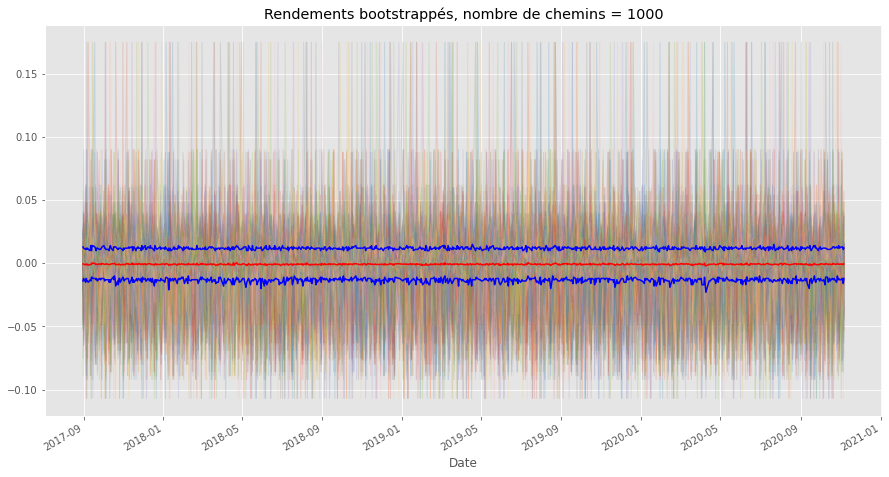

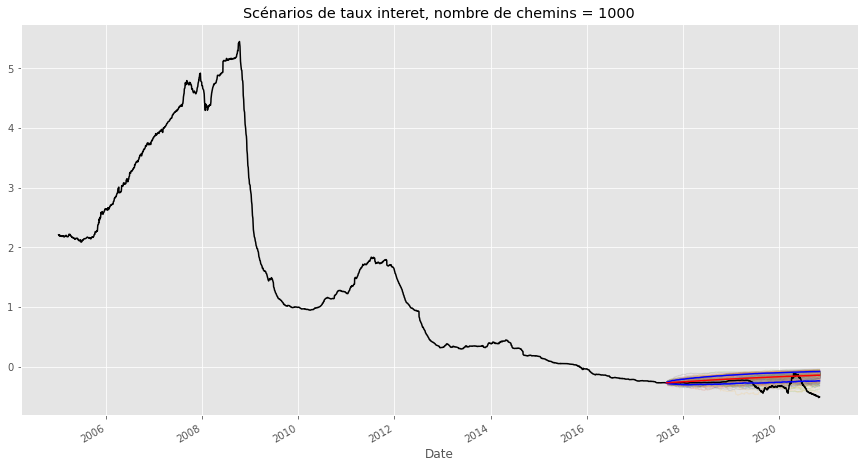

In [14]:
serie.historical_simulation(1000)

## IV - Filtered Historical Simulation <a class="anchor" id="chapter4"></a>

[Retour Sommaire](#sommaire)

<u><strong> Etape 1 :</strong> Trouver le meilleur modèle de volatilité conditionnel (GARCH) pour le rendement à modéliser </u>

Pour rappel, nous avons défini une fonction <i> best_param_garch </i> en <strong> III.1.1 </strong>. Nous allons nous en servir afin de trouver le meilleur modéle GARCH

<u><strong> Etape 2 : </strong> Standardisation des rendements </u>

<u><strong>Etape 3 :</strong> Bootstrapping à partir des rendements standardisés </u>

In [15]:
# serie.filtered_historical_simulation_GARCH(500)

##### Complément : FHS utilisant la fenêtre glissante - Version finale adoptée

<div style="text-align: justify">
En utilisant une modélisation de la volatilité conditionnel via un GARCH, nous augmentions de façon très importante le temps de calcul de notre fonction de FHS. Cela s'explique par la complexité de trouver un nouveau GARCH pertinent pour chaque nouvelle donnée rajouté et pour une fenêtre de 20 données glissantes. Pour pallier à ce problème, nous avons gardé dans la version finale du code uniquement la version du FHS avec une fenêtre glissante. C'est via cette fenêtre que nous calculons de manière simple la volatilité de chaque fenêtre pour standardisés les rendements.
</div>

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-31,-2.588075e-03,-7.387361e-04,0.000000e+00,5.642906e-04,-1.927567e-03,0.000000,-2.609372e-04,8.529325e-04,7.385349e-04,-2.161452e-03,...,-9.759563e-04,3.147053e-04,-4.835725e-03,0.000000e+00,-0.000243,-1.706557e-03,6.042180e-04,5.880176e-04,-0.001462,6.210887e-04
2017-09-01,-9.252065e-04,0.000000e+00,-6.993070e-04,-8.551042e-04,0.000000e+00,-0.006440,-1.666091e-03,-6.158135e-04,4.224892e-05,3.384128e-04,...,3.693259e-04,-4.688820e-03,-1.462279e-03,1.963087e-03,0.000344,1.141628e-03,-6.612127e-04,-1.061282e-03,0.000076,7.029510e-04
2017-09-04,1.623856e-03,3.132268e-04,0.000000e+00,1.013304e-03,-1.996965e-03,0.000000,3.734075e-03,-6.470161e-04,-1.007861e-03,3.614988e-04,...,-7.287551e-04,-2.387396e-03,4.139464e-04,0.000000e+00,0.000260,-1.485328e-03,-6.646097e-04,5.258364e-04,0.000797,6.067277e-04
2017-09-05,-6.129310e-04,-1.434653e-03,6.516327e-04,0.000000e+00,-1.831963e-04,0.000257,-6.008706e-04,-3.977441e-04,2.856701e-04,7.097321e-04,...,7.913709e-04,-2.112810e-04,-1.105666e-03,0.000000e+00,0.000242,-1.228190e-03,0.000000e+00,-1.394876e-03,-0.000608,3.212372e-04
2017-09-06,-4.777844e-04,-1.832445e-04,1.665550e-04,7.262145e-04,-1.078878e-03,-0.001919,8.435783e-04,2.982993e-04,-2.624669e-04,5.628676e-04,...,-7.278513e-04,-1.838468e-04,-1.107830e-03,-1.076373e-03,0.000000,-3.086326e-03,-3.314635e-04,-9.278063e-04,0.000000,-1.969695e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-02,-2.194609e+06,4.615403e+04,1.244596e+09,-7.080903e+07,-4.153431e+06,-27886.570039,-4.971878e+06,0.000000e+00,4.076568e+09,1.541190e+07,...,-7.935944e+09,8.870470e+05,0.000000e+00,-4.848626e+08,231860.618684,-8.247245e+09,2.407159e+11,-3.713633e+06,0.000000,-3.658264e+08
2020-11-03,5.930609e+06,0.000000e+00,-6.479018e+09,-1.564615e+07,-1.838028e+06,0.000000,1.867356e+06,0.000000e+00,-1.166323e+09,-4.667945e+07,...,-1.301644e+09,-1.783446e+06,-6.920160e+09,-2.128752e+09,-215977.506769,0.000000e+00,2.005940e+12,3.144268e+06,-105392.900086,2.955716e+07
2020-11-04,-1.356374e+06,0.000000e+00,1.674209e+09,-9.737542e+06,-1.587188e+06,71336.196710,-3.758821e+06,-7.549460e+07,1.803514e+09,4.864536e+07,...,-7.956223e+09,9.799334e+04,2.274075e+08,-6.256788e+08,-147172.815982,-7.312044e+10,-2.436567e+12,9.351161e+05,0.000000,-9.144644e+07


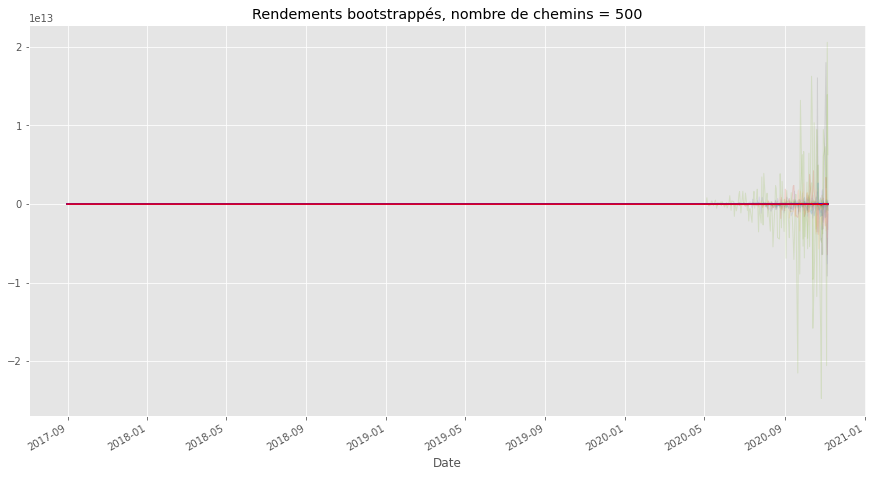

In [58]:
serie.filtered_historical_simulation_glissant(500,20)

## V - Fonction de performance <a class="anchor" id="chapter5"></a>

[Retour Sommaire](#sommaire)

Nous allons maintenant comparer de façon statistique les performances des scénarios générés. Pour cela, nous avons réalisé une fonction comprenant un certain nombre de mesures permettant de comparer les différents scénarios.

#### V.1 - Fonctions de mesures <a class="anchor" id="chapter5.section1"></a>

Nous avons commencé par définir 3 fonctions simples qui permettent de calculer : 

- la déviation en valeur absolue à la médiane d'une distribution de fonction 
- l'asymétrie d'une distribution de fonction 
- le kurtosis d'une distribution de fonction 

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant un ou plusieurs jeux de distributions.

In [31]:
#This function calculates the absolute median deviation of a distribution function.
def Median_Abs_dev(data):    
    mads =[]
    for col in data.columns:
        series = data[col]
        mads.append(series.mad())
    return(mads)

In [32]:
#This function calculates the skewness value of a distribution function.
def skewness(data):    
    skews =[]
    for col in data.columns:
        series = data[col]
        skews.append(series.skew())
    return(skews)

In [33]:
#This function calculates the kurtosis value of a distribution function
def kurtosis(data):
    kurtos =[]
    for col in data.columns:
        series = data[col]
        kurtos.append(series.kurt())
    return(kurtos)


Nous avons ensuite choisi 3 tests permettant de comparer la <u>moyenne et la variance entre deux distributions</u> de fonctions : 

- <strong> Z-test </strong> : Comparaison de la moyenne des distributions
- <strong> (Student) t-test </strong>: Comparaison de la moyenne des distributions
- <strong> F-test </strong>: Comparaison de la variance des distributions

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant une ou plusieurs méthodes prédictions.

<strong><u> Z-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ Z = \frac{\bar{X} - \mu_{0}}{s} $$

où : 
- $Z$ : Z-test
- $\bar{X}$ : moyenne de l'échantillon
- $\mu_{0} $ : espérance
- $s$ : écart-type


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
- https://en.wikipedia.org/wiki/Z-test

In [34]:
#  ! WARNING ! -> This function calculates the Z-Score of one distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column
from statsmodels.stats.weightstats import ztest

def Z_score(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test) 

<strong><u> (Student) t-test  - Comparaison de la moyenne des distributions </strong></u> 

$$ t = \frac{m - \mu_{0}}{s/ \sqrt{n}} $$

où : 
- $t$ : t-test
- $m$ : espérance
- $\mu_{0} $ : valeur théorique
- $s$ : écart-type
- $n$ : taille de l'échantillon


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
- https://en.wikipedia.org/wiki/Student%27s_t-test

In [35]:
#  ! WARNING ! -> This function calculates the t-Score of two distribution.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def t_score(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        
        else:
            series = data[col]
            stat_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(stats.ttest_ind(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)  

<strong><u> F-Test  - Comparaison de la variance des distributions </strong></u> 

$$ F = \frac{Explained Variance}{Unexplained Variance} $$

avec :

$$ Explained Variance = \sum_{i = 1}^{K}n_{i} ({\bar {Y}}_{i \cdot} - {\bar {Y}})^{2} / (K - 1) $$
et
$$ Unexplained Variance = \sum_{i = 1}^{K} \sum_{j = 1}^{n_{i}} ({\bar {Y}}_{ij \cdot} - {\bar {Y}}_{i \cdot})^{2} / (N - K) $$

où 
- $ {Y}_{ij} $ est la j-ème observation dans la i-ème sur K groupes
- N : taille globale de l'échantillon 


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html
- https://en.wikipedia.org/wiki/F-test

In [36]:
#  ! WARNING ! -> This function calculates the F-test of two distributions
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

from scipy.stats import f_oneway

def F_test(data, percentage_test):
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(f_oneway(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)

Nous avons ensuite choisi 3 mesures permettant de  <u>comparer deux distributions </u> de fonctions : 

- <strong> Test de rang de Mann-Whitneyu </strong>
- <strong> Test de rang de Wilcoxon </strong>
- <strong> Distance de Wasserstein </strong>

NB: Chacune de ces fonctions est réalisée de telle sorte qu'elles peuvent être appliquées à un dataset comportant une ou plusieurs méthodes prédictions.

<strong><u> Test de rang de Mann-Whitneyu  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

La statistique U de Mann-Whitney correspondante est définie comme suit:

$$ U = \sum_{i = 1}^{n} \sum_{j = 1}^{m} S(X_{i}, Y_{j})  $$

avec

$
  S (X, Y) = \left\{
          \begin{array}{ll}
            1 & \qquad \mathrm{si}\quad Y < X \\
            \frac{1}{2} & \qquad \mathrm{si}\quad Y = X \\
            0 & \qquad \mathrm{si}\quad Y > X \\
          \end{array}
        \right.
$


Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
- https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [37]:
#  ! WARNING ! -> This function calculates the Mann_Whitneyu Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Mann_Whitneyu(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col]
            stat_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(mannwhitneyu(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test)  

<strong><u> Test de rang de Wilcoxon  </strong></u> 

Laisser $X_{1}, \ldots, X_{n}$ être un échantillon i.i.d de X et $Y_{1}, \ldots, Y_{n}$ un échantillon i.i.d de Y avec X et Y indépendants l'un de l'autre. 

Le test statistique de Wilcoxon est défini comme suit:

$$ W = \sum_{i = 1}^{N_{r}} [sgn(x_{2,i} - x_{1,i}) * R_{i}]$$

avec
- $W$ : test statistique 
- $N_{r}$ : taille de l'échantillon
- $sng$ : signe de la function
- $x_{2,i} - x_{1,i}$ : paires classées correspondantes des deux distributions
- $R_{i}$ : rang i

Lien : 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
- https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test

In [38]:
#  ! WARNING ! -> This function calculates the Wilcoxon Test between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wilcoxon(data, percentage_test) :
    stat_val = []
    res_p_val = []
    res_pct_test = []
    for col in data.columns:
        if col == 'Testing Set':
            stat_val.append('NaN')
            res_p_val.append('NaN')
            res_pct_test.append('NaN')
        else:
            series = data[col] 
            stat_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[0])
            res_p_val.append(wilcoxon(np.array(data['Testing Set']) , np.array(data[col]))[1])
            if float(ztest(np.array(data['Testing Set']) , np.array(data[col]))[1]) >= float(percentage_test):
                res_pct_test.append(1)
            else: 
                res_pct_test.append(0)
        
    return (stat_val, res_pct_test) 

<strong><u> Distance de Wasserstein </strong></u> 

La première distance de Wasserstein entre les distributions $u$ et $v$ est:


$$ l_{1}(u,v) =  \inf_{\substack{\pi \in \Gamma(u,v)}} \int_{\mathbb{R}x\mathbb{R}} |x - y|d\pi(x,y)$$

Lien : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html

In [39]:
#  ! WARNING ! -> This function calculates the Hellinger distance between two distributions.
# The 1st index of the general Dataframe MUST be the Training Set or Testing Set column

def Wasserstein(data) :
    res = []
    for col in data.columns:
        series = data[col]
        res.append(wasserstein_distance(data['Testing Set'], data[col]))
    return(res)

#### V.2 - Fonction Describe   <a class="anchor" id="chapter5.section2"></a>

[Retour Sommaire](#sommaire)

Grâce à toutes les fonctions présentées dans la partie précédente, nous avons réalisé une fonction globale qui, pour un unique dataset en entrée (au format DataFrame), retourne un tableau comparatif comportant les éléments suivants : 

- Espérance & Variance 
- Min / Q25% / Médiane / Q75% / Max
- Déviation de la médiane en valeure absolue
- Asymétrie & Kurtosis
- <strong> Z-test </strong> & <strong>t-test</strong> (pour la comparaison de la moyenne)
- <strong>F-test </strong>(pour la comparaison de la variance)
- <strong>Test de rang de Mann-Whitneyu </strong> & <strong> Test de Wilcoxon</strong> (pour comparer le ranking de deux distributions)
- <strong> Mesure de Wasserstein </strong> (pour comparer la distance entre deux distributions)


<u> NB:</u> Cette fonction est réalisée de telle sorte qu'elle peut être appliqué à un dataset comportant un ou plusieurs jeux de distributions. Dans le cas d'un dataset multiple, les distance citées précédement seront toujours calculées en fonction de la première colonne de ce dataset.

<strong><u> Conséquence: </strong></u>  Il faut impérativement placer les valeurs réelles dans la première colonne de notre DataFrame, afin de pouvoir comparer chaque simulation avec les valeurs réelles, et ainsi comparer la performance de chacunes de nos simulations.

Nous testons notre fonction de performance sur le dataframe de prédictions, qui comporte : 

- Nos données réelles
- La moyenne de nos scénarii générés par Historical Simulation
- La moyenne de nos scénarii générés par Filtered Historical Simulation

In [40]:
describe = serie.describe(500, 20, 0.05)

<Figure size 432x288 with 0 Axes>

In [41]:
# Mesures statistiques
describe_mesure = describe[0]
describe_mesure

,Testing Set,Historical Simulation,Filtered HS,Generative Adversarial Network
count,810.000000,810.000000,810.000000,810.000000
mean,-0.000295,-0.000785,-1142717150.839085,0.002082
std,0.006326,0.011541,29067244378.348274,2.616486
min,-0.031000,-0.088222,-461511586340.594177,-26.284065
25%,-0.001000,-0.002482,-2684.976234,-0.020936
50%,0.000000,-0.000016,-0.000016,-0.004269
75%,0.001000,0.001987,120.444913,0.010136
max,0.054000,0.094440,287203158415.940247,27.557434
Median Absolute Deviation,0.003265,0.005621,5862270963.434307,0.457877
skew,1.725536,-0.883730,-2.822358,0.432272


In [42]:
# Tests statistiques
describe_test = describe[1]
describe_test

,Historical Simulation,Filtered HS,Generative Adversarial Network
Wasserstein Distance,0.002379,4890845030.854721,0.450013
Wilcoxon Test,139826.623000,132001.226000,138015.163793
Wilcoxon H0 % Acceptance,0.862000,0.786000,1.000000
Mann-Whitneyu Test,321518.533000,306084.356000,277191.379310
Mann-Whitneyu H0 % Acceptance,0.862000,0.786000,1.000000
F_test,1.855817,2.359293,0.036624
F_test H0 % Acceptance,0.862000,0.786000,1.000000
t_test,1.056438,1.178504,-0.028059
t_test H0 % Acceptance,0.862000,0.786000,1.000000
Z_test,1.056438,1.178504,-0.028059


## VI - Generative Adversarial Network (GAN) <a class="anchor" id="chapter6"></a>

[Retour Sommaire](#sommaire)

Ci dessous, un condensé du code GAN. Il est préférable de le faire tourner sur la version <b> Google Collab</b> prévue à cet effet !
<br></br>
<br></br>
Le lien est le suivant : https://colab.research.google.com/drive/1Z8kilfIywiMMuLTErvJ9_5tOXcuNCQUJ

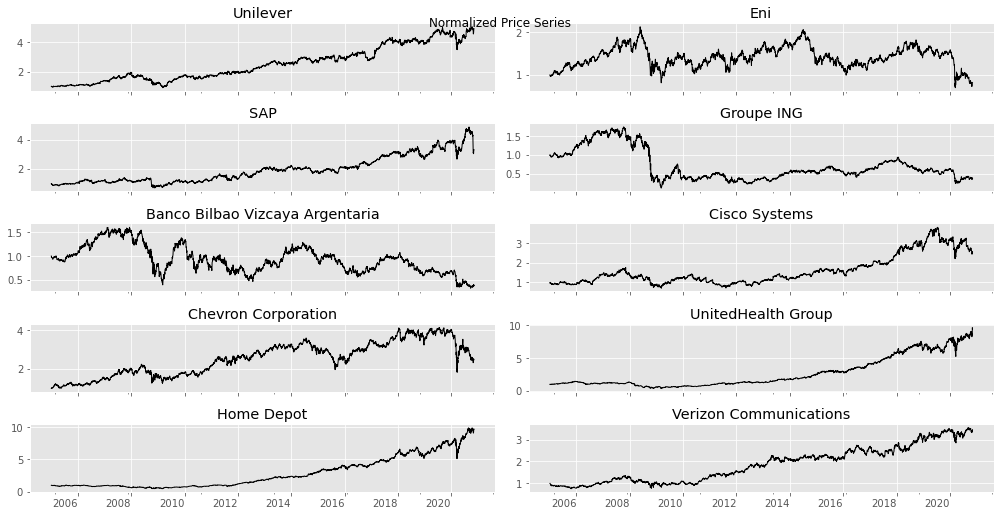

In [43]:
#Definition du dataset 

df = Stocks

l_title = [Stocks.columns[i] for i in range(len(Stocks.columns))]
axes = df.div(df.iloc[0]).plot(subplots=True, figsize=(14, 14), layout=(10, 2), title= l_title, 
                               legend=False, rot=0, lw=1, color='k')
for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine()

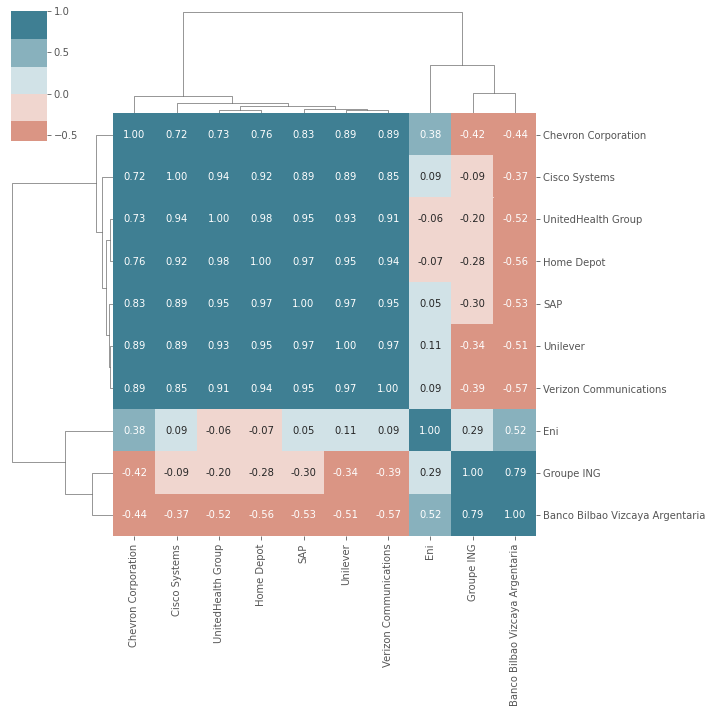

In [44]:
# Correlation
sns.clustermap(df.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0)

In [46]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

#Formula MinMaxScaler
#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min

In [47]:
# Create rolling window sequences containing overlapping sequences 
seq_len = 24
data = []

for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)


# Create tf dataset
batch_size = 128

real_series = (tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=n_windows).batch(batch_size))
real_series_iter = iter(real_series.repeat())

# Create a random series generator
n_seq = len(df.columns)               #ATTENTION ! Il faut mettre ici le nbr de series que l'on étudie
                                      #Ici = 2 (STOXX50 et S&P500) - Penser à modifier si besoin

def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))


random_series = iter(tf.data.Dataset.from_generator(make_random_data, output_types=tf.float32).batch(batch_size).repeat())

# Network Parameters
hidden_dim = 16
num_layers = 3

Apprentissage des models - FAIRE TOURNER SUR GOOGLE COLLAB 

In [ ]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

# input placeholder
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')


# Autoencoder -> rnn -> Reconstruction loss
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units, return_sequences=True, name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units, activation='sigmoid', name='OUT')], name=name)

embedder = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=hidden_dim, name='Embedder')

recovery = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=n_seq, name='Recovery')

# Adversarial network -> unsupervised learning part -> Unsupervised Loss
generator = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=hidden_dim, name='Generator')

discriminator = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=1, name='Discriminator')

supervisor = make_rnn(n_layers=2, hidden_units=hidden_dim, output_units=hidden_dim, name='Supervisor')


# Training - Settings
train_steps = 10000
gamma = 1

# Generic Loss Functions
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Part 1 - Autoencoder training
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X, outputs=X_tilde, name='Autoencoder')

autoencoder_optimizer = Adam()

@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    
    return tf.sqrt(embedding_loss_t0)


for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)
        
        
# Part 2 supervised learning

supervisor_optimizer = Adam()

@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    
    return g_loss_s

for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

In [ ]:
# Sauvegarde du model de supervision 
supervisor.save(log_dir / 'supervisor')
supervisor.save('supervisor_h5.h5')


In [ ]:
# Joint training - Generator - Adversarial Architecture - Supervised
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z, outputs=Y_fake, name='AdversarialNetSupervised')

# Adversarial Architecture in Latent Space
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z, outputs=Y_fake_e, name='AdversarialNet')

# Mean & Variance Loss
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z, outputs=X_hat, name='SyntheticData')

def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

# Discriminator
Y_real = discriminator(H)
discriminator_model = Model(inputs=X, outputs=Y_real, name='DiscriminatorReal')

# Optimizer
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()


# Generator Train Step

@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake), y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e), y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised + generator_loss_unsupervised_e + 
                          100 * tf.sqrt(generator_loss_supervised) + 100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss


# Embedding Train Step
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

# Discriminator Train Step

def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real), y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake), y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e), y_pred=y_fake_e)
    return (discriminator_loss_real + discriminator_loss_fake + gamma * discriminator_loss_fake_e)

@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

#############################################################################################################
################################### Training Loop ###########################################################
#############################################################################################################

step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)


In [ ]:
# SAVE MODEL - Persist Synthetic Data Generator
synthetic_data.save(log_dir / 'synthetic_data')

synthetic_data.save('synthetic_data_h5.h5')
from google.colab import files
files.download('synthetic_data_h5.h5')

Génération des résultats

In [ ]:
# Generate paths of Synthetic Data
nb_paths = 500
paths = []
for n in range(nb_paths):
    generated_data = []
    for i in range(int(n_windows / batch_size)):
        Z_ = next(random_series)
        d = synthetic_data(Z_)
        generated_data.append(d)
    generated_data = np.array(np.vstack(generated_data))
    generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
    paths.append(generated_data)

In [ ]:
# SAVE MODEL - Persist Synthetic Data Generator
generated_data.save(log_dir / generated_data.npy)

In [ ]:
# Vérification de la taille de la matrice generated data
print(len(generated_data))
print(len(generated_data[0]))
print(len(generated_data[0][0]))